In [45]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cupy 
import numpy 

from sscPrain import propagation

# -*- coding: utf-8 -*-

# manage the imports
import numpy as np
import matplotlib.pyplot as plt
import os
import time


# %load_ext autoreload
# %reload_ext autoreload

# FRESNEL PROPAGATOR

# function [Ef,x,y,G,E0fft,fx,fy,H,indx] = FresnelPropagator(E0, ps, lambda0, z, background)
#
# This function computes the double-slit diffraction pattern using the 
# Fresnel Approximation. This code was modified from Dan and Aamod's
# Fresnel propagator codes.
#
# Parameters: E0 - initial complex field in x-y source plane
#             ps - pixel size in microns
#             lambda0 - wavelength in nm
#             z - z-value (distance from sensor to object)
#             background - optional background image to divide out from
#                          input field
#
# Returns: Ef - 
#          x - 
#          y - 
#          G - 
#          E0fft - 
#          fx - 
#          fy - 
#          H - 
#

def abssqr(x):
    # this is what a detector sees (only intensities)
    return np.real(x*np.conj(x))

def FT(x):
    # this only defines the correct fwd fourier transform including proper shift of the frequencies
    return np.fft.fftshift(np.fft.fft2(x)) # Fourier transform and shift

def iFT(x):
    # this only defines the correct inverse fourier transform including proper shift of the frequencies
    return np.fft.ifft2(np.fft.ifftshift(x)) # inverse Fourier transform and shift
    
def propagation_fresnel(E0, z,energy,ps ):
    # Parameters: E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    E0 = E0.get()
    lambda0 = 1e9 * planck * speed_of_light / energy # nanometers
    ps = ps*1e6 #microns
    
    upsample_scale = 1;                 # Scale by which to upsample image
    n = upsample_scale * E0.shape[1] # Image width in pixels (same as height)
    grid_size = ps * n;                 # Grid size in x-direction
    

    # Inverse space
    fx = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    fy = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    Fx, Fy = np.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2));
    # sphere=exp(i*k/2/zc*(xx.^2+yy.^2));
    H = np.exp(1j*(2 * np.pi / lambda0) * z) * np.exp(1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    #H= cos(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0)+1i.*sin(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0);
    
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    
    # Multiply spectrum with fresnel phase-factor
    G = H * E0fft
    Ef = iFT(G) # Output after deshifting Fourier transform
    
    return cupy.asarray(Ef)

def propagation_fresnelPAOLA(wavefront,distance,energy,pixel_size):
    # create dictionary
    dic = {}

    # Propagation and phase retrieval parameters
    dic['gpu'] = [0]
    dic['beamgeometry'] = 'conebeam'
    dic['z1'] = (0,0) # (z1x,z1y) for feature 1e-6, z1 = 83E-3, else z1 = 25E-3
    dic['z2'] = (distance,distance) # (z2x,z2y) mobpix
    dic['ratio'] = 0 # add known ratio of phase/attenuation (1 material only). Set zero for unknown ratio.
    dic['blocksize'] = 1 # 

    # Rotation of sample and detector for propagation and phase retrieval
    dic['rotationdetector'] = (0,0) # set detector rotation in rad: (rotx,roty)

    # Rotation of sample mass center and poni for propagation and phase retrieval
    dic['samplemasscenter'] = (0,0) # Set Sample center (center of mass) in detector coordinates, in meters: (sx,sy) 
    dic['poni'] = (0,0) # Set poni (conebeam central ray) in detector coordinates, in meters: (px,py)

    # Detector and beam profiles
    dic['energy'] = energy # in eV
    dic['detpixelsize'] = (pixel_size,pixel_size) # (px,py) in meters


    # Fresnel propagation GPU
    # input:
    # dic - dictionary (above)
    # phantom - dimension [z,y,x]. For 2D phantom, dimension [1,y,x]
    # output:
    # intensidade - |propagacao|**2
    # propagacao  - dado propagado

    # wavefront = wavefront/np.max(wavefront)
    wavefront = wavefront.get()
    # print(np.max(wavefront),np.min(wavefront))
    intensidade, propagacao = propagation.propagation_fresnelnumber(wavefront, dic)
    # print(np.max(wavefront),np.min(wavefront),np.max(np.abs(wavefront)),np.max(propagacao),np.min(propagacao),np.max(np.abs(propagacao)))
    propagacao = cupy.asarray(propagacao)
    return propagacao

def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    ysize, xsize = wavefront.shape
    
    x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
    y_array = np.linspace(-ysize/2,ysize/2-1,ysize)
    
    fx = x_array/(xsize)
    fy = y_array/(ysize)
    
    FX,FY = np.meshgrid(fx,fy)

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    elif propagator == 'fresnel':
        # % Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # % multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def PIE_update(params,difference,probe,obj,px,py,offset,algorithm="rPIE",update_obj=True,update_probe=True):
    """
     PIE: requires only regularization parameters
    ePIE: requires only step parameter
    rPIE: requires only regularization parameters. It is independent of the maximum probe value of the experiment. See https://doi.org/10.1364/OPTICA.4.000736
    mPIE: requires both step and regularization parameters
    """
    #TODO: update only where difpad is valid?
    #TODO: update probe using previous object instead of updated one?
    reg_obj,reg_probe,step_obj,step_probe,momentum_obj,momentum_probe,T_lim = params
    obj_section = obj[py:py+offset[0],px:px+offset[1]]
    if update_obj:
        if algorithm == "mPIE": # rPIE update function
            obj[py:py+offset[0],px:px+offset[1]] = obj_section + step_obj*difference*probe.conj()/ ( (1-reg_obj)*np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max() )
        elif algorithm == "rPIE":
            obj[py:py+offset[0],px:px+offset[1]] = obj_section +         1*difference*probe.conj()/ ( (1-reg_obj)*np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max() )
        elif algorithm == "ePIE": #ePIE update function
            obj[py:py+offset[0],px:px+offset[1]] = obj_section + step_obj*difference*probe.conj()/(np.abs(probe)**2).max()
        elif algorithm == "PIE":
            obj[py:py+offset[0],px:px+offset[1]] = obj_section + difference*probe.conj()*np.abs(probe)/((np.abs(probe).max()*(np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max())))
        else: 
            sys.exit("Wrong algorithm. Select PIE, ePIE, rPIE or mPIE")
    if update_probe:
        if algorithm == "mPIE": # rPIE update function
            probe = probe + step_probe*difference*obj_section.conj()/ ( (1-reg_probe)*np.abs(obj_section)**2+reg_probe*(np.abs(obj_section)**2).max() )
        elif algorithm == "rPIE":
            probe = probe +          1*difference*obj_section.conj()/ ( (1-reg_probe)*np.abs(obj_section)**2+reg_probe*(np.abs(obj_section)**2).max() )
        elif algorithm == "ePIE": #ePIE update function
            probe = probe + step_probe*difference*obj_section.conj()/(np.abs(obj)**2).max()
        elif algorithm == "PIE":
            probe = probe +          1*difference*obj_section.conj()*np.abs(obj_section)/ ( (np.abs(obj_section).max()*np.abs(obj_section)**2+reg_probe*(np.abs(obj_section)**2).max()))
        else:
            sys.exit("Wrong algorithm. Select PIE, ePIE, rPIE or mPIE")        
    return obj, probe

def momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,momentum_obj,momentum_probe):
    T_counter += 1 
    if T_counter == T_lim : # T parameter in mPIE paper
        probeVelocity  = probeVelocity*momentum_probe + (probe - P_aux)
        objVelocity = objVelocity*momentum_obj  + (obj - O_aux)  
        obj = O_aux + objVelocity
        probe = P_aux + probeVelocity 

        O_aux = obj
        P_aux = probe            
        T_counter = 0
        # T_counter = T_lim - 1
    return T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def magnitude_constraint(estimate,data):
    return np.sqrt(data)*estimate/np.abs(estimate)

def pinhole_constraint(wavefront,pinhole):
    wavefront[pinhole<=0] = 0
    return wavefront

def support_constraint(wavefront,support):
    wavefront[support <= 0] = 0
    return wavefront

if 1:
    def update_function(object,probe,wavefront,previous_wavefront,reg_obj,reg_probe):
        updated_object = object + reg_obj*probe.conj()*(wavefront-previous_wavefront)/np.abs(np.max(probe))**2
        updated_probe = probe + reg_probe*object.conj()*(wavefront-previous_wavefront)/np.abs(np.max(object))**2
        return updated_object, updated_probe
else:
    def update_function(object,probe,wavefront,previous_wavefront,reg_obj,reg_probe):
        updated_object = object + 1*(wavefront-previous_wavefront)*probe.conj()/ ( (1-reg_obj)*np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max() )
        updated_probe  = probe  + 1*(wavefront-previous_wavefront)*object.conj()/ ( (1-reg_probe)*np.abs(object)**2+reg_probe*(np.abs(object)**2).max() )
        return updated_object, updated_probe

def mPIE_loop(difpads, positions,object_guess,probe_guess, mPIE_params,experiment_params, iterations):
    print("Starting PIE...")
    
    mPIE = True
    use_rPIE_update_function = True
    
    _,_,_,_,momentum_obj,momentum_probe,T_lim = mPIE_params
    
    offset = probe_guess.shape
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    # difpads = np.asarray(difpads)
    # obj = np.asarray(object_guess)
    # probe = np.asarray(probe_guess)
    obj = object_guess
    probe = probe_guess
    
    print(type(obj),obj.shape)
    for j in range(iterations):

        if j%10 ==0 : print(f'\tIteration {j}/{iterations}')
        error, O_aux, P_aux = 0, obj+0, probe+0
        for i in np.random.permutation(len(difpads)):  
        # for i in range(len(difpads)):  
            px, py = positions[:,1][i],  positions[:,0][i]
            measurement = difpads[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe

            """ Propagate + Update + Backpropagate """
            exitWaveNew = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)
            
            difference = exitWaveNew - exitWave
            
            obj, probe = PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function)
            
            if mPIE == True: # momentum addition
                T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,momentum_obj,momentum_probe)

                
        # if j%2 == 0: # Print iteration
        #     figure, subplot = plt.subplots(1,2)
        #     subplot[0].imshow(np.abs(obj.get()),cmap=colormap)
        #     subplot[1].imshow(np.abs(probe.get()),cmap=colormap)
        #     subplot[0].set_title('Object')
        #     subplot[1].set_title('Probe')
        #     figure.suptitle(f'Iteration #{j}')
        #     plt.show()
        #     plt.close()

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()

    return obj, probe

def get_error(wavefront,model):
    return np.sum(np.abs(wavefront-model))

def projection_M_gpu( x, data ):
    fft    = cupy.fft.fftn( x ) 
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
    diff =  numpy.abs(fft) - data 
    adiff = numpy.abs(diff)
    
    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]
    
    tol = 1e-5 #jump@
    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )
    result = cupy.fft.ifftn( result )
    return result
    
    
def projection_S ( x, supp ):
    return x * supp


def slit_PWCDI(DP, object, pinhole, iterations, beta=0.9,reg_obj=0.9,reg_probe=0.1,apply_support = False,    pcentage = 1e-9):
    
    """ Estimate support from auto-correlation """
    autocorr = np.abs(np.fft.fftshift( np.fft.ifft2( DP ) ))
    support = np.where(autocorr>pcentage*np.max(autocorr),1,0)

    support = pinhole
    
    if 0:
        figure, ax = plt.subplots(1,4,dpi=150)
        ax1, ax2,ax3,ax4 = ax.ravel()
        ax1.imshow(autocorr), ax1.set_title("AC")
        ax2.imshow(autocorr,norm=LogNorm()), ax2.set_title("AC Log")
        ax3.imshow(support), ax3.set_title("Support")
        ax4.imshow(0.5*pinhole+support), ax4.set_title("Pinhole + Support")
    
    DP = cupy.asarray(DP)
    DP[DP>0] = cupy.asarray(cupy.sqrt(DP[DP>0]))
    object = cupy.asarray(object)
    pinhole   = cupy.asarray(pinhole)
    complement_support  = cupy.array( 1-pinhole )
    
    probe = propagation_fresnel(pinhole,distance_pinhole,energy,object_pixel_size)
    wavefront = object*probe
    
    wavefront = cupy.asarray(wavefront)
    probe = cupy.asarray(probe)
    
    if 1: 
        figure, ax = plt.subplots(1,5,dpi=200)
        ax1,ax2,ax3,ax4,ax5 = ax.ravel()
        try:
            model = phantom*pinhole.get()
            ax1.imshow(phantom), ax1.set_title("Phantom")
            ax3.imshow(model), ax3.set_title("Product")
        except:
            pass
        ax2.imshow(pinhole.get()), ax2.set_title("Pinhole")
        ax4.imshow(support), ax4.set_title("Support")
        ax5.imshow(DP.get(),norm=LogNorm()) , ax5.set_title("Measurement")
        for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])

    """ Phase-retrieval loop """
    for niteration in range(0,iterations):#phase_retrieval_iterations):
        if niteration+1 % 100 == 0 : print(niteration)
        previous_wavefront = wavefront
        """ Fourier Space-constraint """
        wavefront = projection_M_gpu( wavefront, DP )
        """ Object support constraint """
        if apply_support == True:
            if niteration < 0.1*iterations:
                half_support = support.copy()
                half_support[support.shape[0]//2::,:] = 0
                wavefront = projection_S(wavefront,cupy.asarray(half_support))
            # else:
                # wavefront = projection_S(wavefront,cupy.asarray(support))
                # wavefront = projection_S( y, pinhole ) + projection_S( wavefront - beta * y,  complement_support )         

        """ Object/probe update """
        probe = wavefront/object
        object, probe = update_function(object,probe,wavefront,previous_wavefront,reg_obj,reg_probe) # update function of the PIE family
        
        """ Pinhole constraint """
        probe = propagation_fresnel(probe,-distance_pinhole,energy,object_pixel_size)
        probe = pinhole_constraint(probe,pinhole) # set wavefront null outside pinhole; set negative values null inside pinhole
        probe = propagation_fresnel(probe,distance_pinhole,energy,object_pixel_size)
       
        wavefront = probe*object

        # if calculate_error:
            # error.append(get_error(wavefront.get(),phantom))
    
    return wavefront.get()



def gaussian_blur(img,sigmax,sigmay=0):
    
    def gaussian(img,sigmax,sigmay):
        
        if sigmay == 0: 
            sigmay = sigmax
            
        ny, nx = img.shape

        sigmax = int(ny*sigmax)//2
        sigmay = int(ny*sigmay)//2        
        
        x = cupy.linspace(0,nx-1,nx)-nx//2
        y = cupy.linspace(0,ny-1,ny)-ny//2
        X, Y = cupy.meshgrid(x,y)
        return cupy.exp(-(X**2/(2*sigmax**2)+Y**2/(2*sigmay**2)))
    
    gaussian2d = gaussian(img,sigmax,sigmay) # define gaussian filter
    filtered = cupy.fft.fftshift(cupy.fft.ifft2((cupy.fft.fft2(img))*((cupy.fft.fft2(gaussian2d))))) # convolution

    return filtered

def thresholding(matrix,threshold):
    return np.where(matrix>threshold*np.max(matrix),1,0)

def shrinkwrap(wavefront,sigma,threshold):
    wavefront = cupy.real(wavefront) 
    wavefront = gaussian_blur(wavefront,sigma)
    support = thresholding(wavefront,threshold)
    return support 


def standard_PWCDI(DP, initial_guess, support, iterations, beta=0.9, pcentage = 1e-9):
    
    DP = cupy.asarray(DP)
    DP[DP>0] = cupy.asarray(cupy.sqrt(DP[DP>0]))
    wavefront = cupy.asarray(initial_guess)
    support   = cupy.asarray(support)
    complement_support  = cupy.array( 1-support )

    """ Phase-retrieval loop """
    for niteration in range(0,iterations):#phase_retrieval_iterations):

        if niteration%10==0:
            plt.figure()
            plt.imshow(support.get())
            plt.show(), plt.close()
        
        y = projection_M_gpu( wavefront, DP )

        # if niteration < 20: # ER with half support
        #     half_support = support.copy()
        #     half_support[support.shape[0]//2::,:] = 0
        #     wavefront = projection_S(y,cupy.asarray(half_support))
        if niteration > 0.9*iterations: #ER with full support
            wavefront = projection_S( y, support )
        else: # HIO
            wavefront = projection_S( y, support ) + projection_S( wavefront - beta * y,  complement_support )         
        
        support = shrinkwrap(wavefront,sigma=0.5,threshold=0.2)    
        complement_support  = cupy.array( 1-support )


    return wavefront.get()



mario: (100, 100, 100) 2.0MB


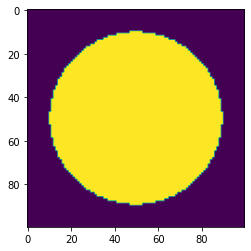

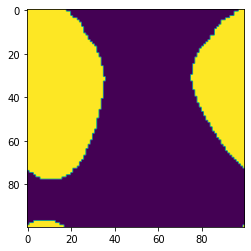

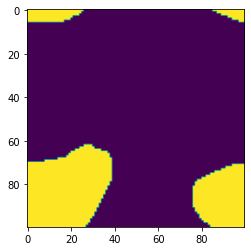

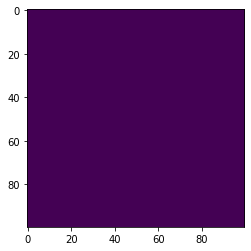

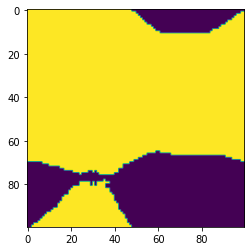

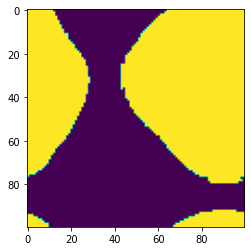

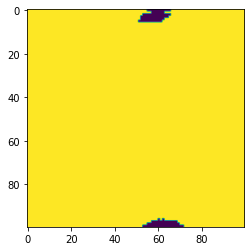

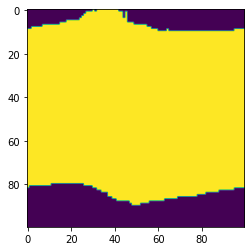

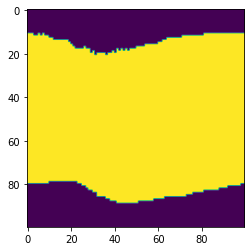

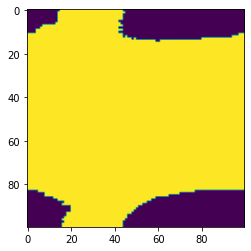

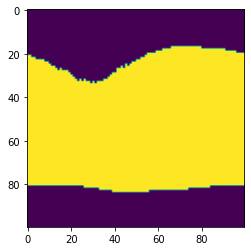

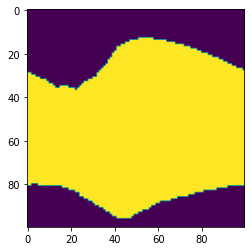

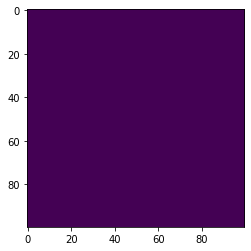

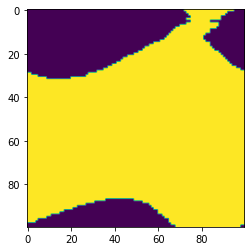

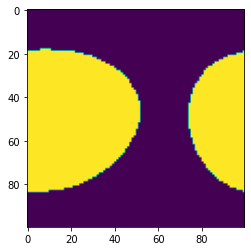

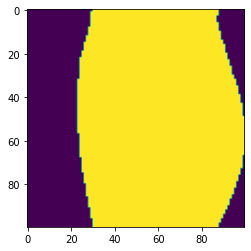

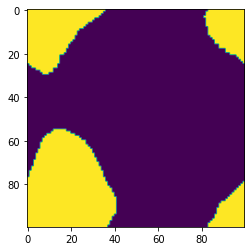

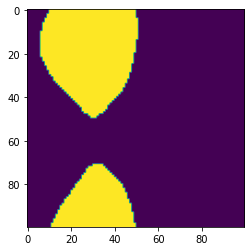

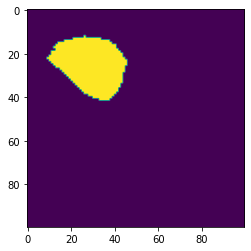

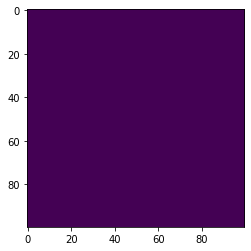

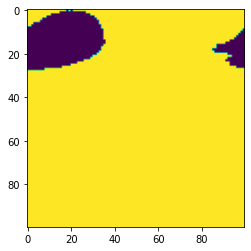

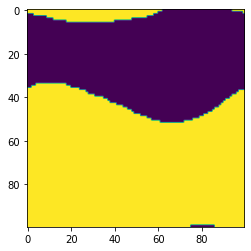

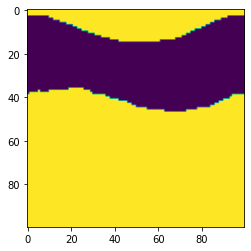

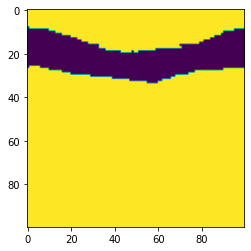

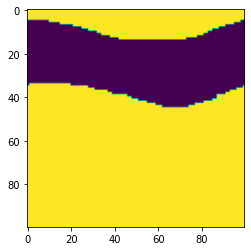

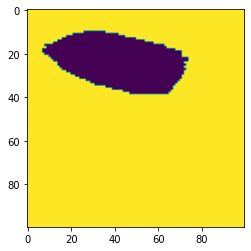

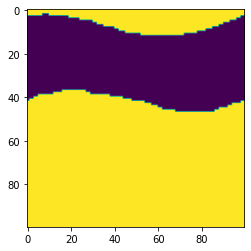

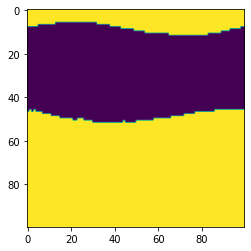

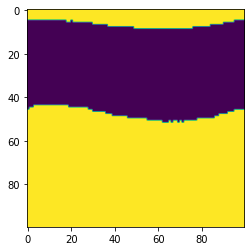

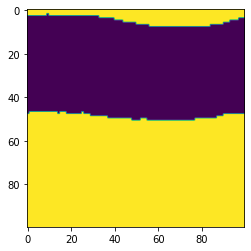

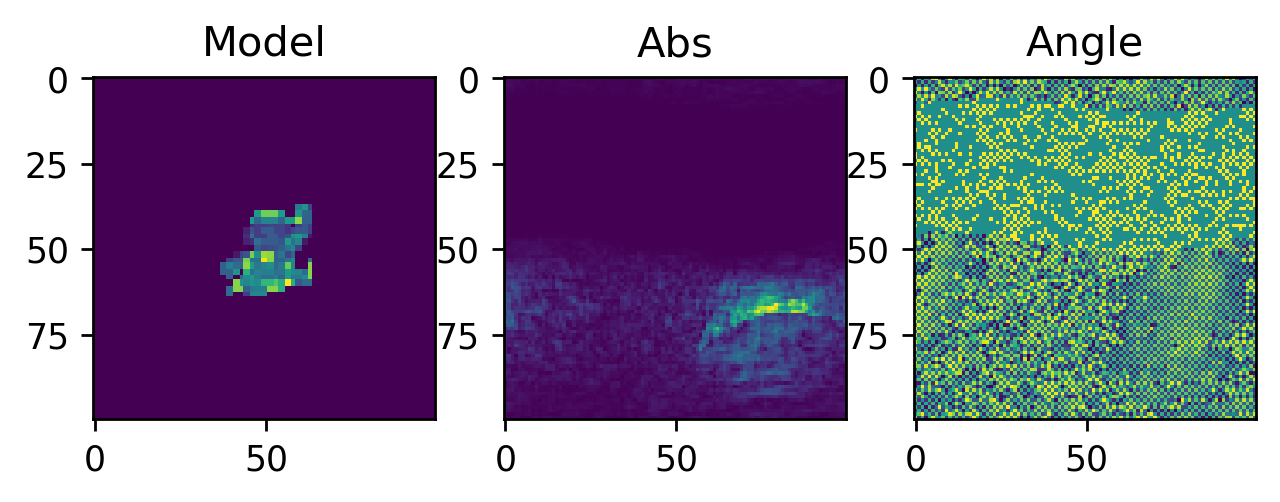

(None, None)

In [46]:
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
N = 100

""" Input parameters """
distance = 28 # meters
energy = 6 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters
n_of_pixels = 3072 
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,distance)
distance_pinhole = 0.21e-3 # m
phase_retrieval_iterations = 300
reg_obj,reg_probe = 0.1, 0.2# PIE update function parameters
apply_support = True
beta = 0.9

""" Load phantom """
if 1: 
    from sscPhantom import donuts, mario
    phantom = mario.createMario(shape=N, noise=False, zoom=0.6)
    phantom = np.sum(phantom,axis=2) + 1
else:
    from PIL import Image
    phantom = np.array(Image.open('moon.tiff'))
    phantom = phantom[0:N,0:N]

""" Pinhole """ 
if 1: # circular
    t = np.linspace(-phantom.shape[0]//2,phantom.shape[0]//2,phantom.shape[0])
    x,y = np.meshgrid(t,t)
    pinhole = np.where((x)**2 + (y)**2 < 20**2,1,0)
elif 0: #triangle
    triangle = np.zeros((N,N))
    t = np.linspace(-N//2,N//2,N)
    x,y = np.meshgrid(t,t)
    sx = -80
    a = 1.5
    triangle[ a*x - sx + y  < 0] = 1
    triangle = np.roll(triangle,15,axis=(0,0))
    pinhole = np.roll(triangle,18,axis=(1,1))
elif 0:
    pinhole = np.where(phantom>1,1,0)
    
""" Load data """
# DP = np.abs( np.fft.fftshift( np.fft.fft2(phantom*propagation_fresnel(cupy.asarray(pinhole),distance_pinhole,energy,object_pixel_size).get()) ) )**2
# DP = np.abs( np.fft.fftshift( np.fft.fft2(phantom*pinhole)))**2
DP = np.abs( np.fft.fftshift(np.fft.fft2(phantom)))**2

# obj = np.random.rand(*DP.shape) + 1j*np.random.rand(*DP.shape)
obj = np.ones_like(DP,dtype=complex)
support = np.where((x)**2 + (y)**2 < 40**2,1,0)

wavefrontPWCDI = standard_PWCDI(DP, obj, support, phase_retrieval_iterations, beta=beta)        
    
figure, ax = plt.subplots(1,3,dpi=250)
ax1, ax2, ax3 = ax.ravel()
ax1.imshow(phantom*pinhole), ax1.set_title("Model")
ax2.imshow(np.abs(wavefrontPWCDI)), ax2.set_title('Abs')
ax3.imshow(np.angle(wavefrontPWCDI)), ax3.set_title('Angle')
plt.show(), plt.close()